In [1]:
from time import time as tictoc
import sys
from my_units import * 
from angular_fn import *
from sky_patch_class import *
from template_fn import *

HomeDir = '../../'
DataDir = '../../../../data/' ### Set this to the directory where you store your data files
ListDir = HomeDir+'lists/'
FigDir = HomeDir+'figs/'
ListTauDir = ListDir+'/coarse_tau/'

# Example template scan (locally)

## Preamble

In [2]:
### Define the patch on the sky where the analysis is done. Currently only works with a circle selection on the sphere.
#sky_p = sky_patch(81.28, -69.78, 5*degree, 50*kpc, 'LMC_disc_5', np.array([1.871, 0.391]), pm_esc=0.2) ### For the LMC
sky_p = sky_patch(12.80, -73.15, 4*degree, 60*kpc, 'SMC_disc_4', np.array([0.686, -1.237]), pm_esc=0.2) ### For the SMC

In [3]:
### Parameters for data cleaning
beta_kernel_sub_0 = 0.1*degree; beta_kernel_sub = 0.06*degree;   # gaussian kernels for background subtraction 
n_iter_sub = 3;                                                  # number of iterations for the background subtraction
disc_radius_no_edge = sky_p.disc_radius - beta_kernel_sub_0 - (n_iter_sub+1)*beta_kernel_sub

### Parameters for the template scan
n_betat = 3.5; ### the template is computed for stars within n_betat*beta_t of the template location
beta_t_deg = str(250)
beta_t = float(beta_t_deg)/10000*degree

In [4]:
### Import the final data
data = np.load(DataDir+sky_p.data_file_name+'_final.npy') ### Much faster than reading in a csv file
### Columns of the numpy array are are: 
### [data['ra'], data['dec'], 
###  data['pm_eff_error']**2, data['pmra_sub']/data['pm_eff_error']**2, data['pmdec_sub']/data['pm_eff_error']**2, 
###  data['parallax_eff_error']**2, data['parallax_sub']/data['parallax_eff_error']**2]

## Execution

In [5]:
### Determine coordinates for the coarse scanning:
### Pixels within a disc of radius disc_radius_no_edge - n_betat_0*beta_t_0 from the stellar target center,
### at an angular scale of approximatly beta_t.

scan_coord = fn_coarse_scan_coord(sky_p.disc_center, disc_radius_no_edge, beta_t, n_betat)
n_locations = len(scan_coord[0])
print('Template scan for beta_t =', np.round(beta_t/degree, 5), 'deg.')
print('Number of template locations:', n_locations,'.')

Template scan for beta_t = 0.025 deg.
Number of template locations: 195609 .


In [8]:
### Compute the template at the first n locations among the total n_locations.
first_loc = 0; last_loc = n_locations; 

### Prepare the data for the template scan at beta_t.
### Pixelate at angular scale approximatly beta_t/10
### Append the stars pixel number as the first column of the array data
nside, scan_pix, data_p = fn_prepare_template_scan(data, [scan_coord[0][first_loc:last_loc], scan_coord[1][first_loc:last_loc]], beta_t)

In [9]:
template_res = fn_template_scan(nside, scan_pix, n_betat, beta_t, data_p)

100%|██████████| 195609/195609 [1:01:13<00:00, 53.25it/s] 


In [10]:
### Save the result of the template scan
np.save(ListTauDir+sky_p.data_file_name+'_tau_b'+beta_t_deg+'_'+str(first_loc)+'_'+str(last_loc), template_res)

## Plots

In [12]:
import matplotlib.pyplot as plt

plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

In [14]:
[ind_ra, ind_dec, ind_tau_ra, ind_tau_dec, ind_n, ind_tau_mon, ind_tau_mon_n, ind_tau_par, ind_par_n] = range(9)
#template_res = np.load(ListTauDir+'')

### Normalization histogram

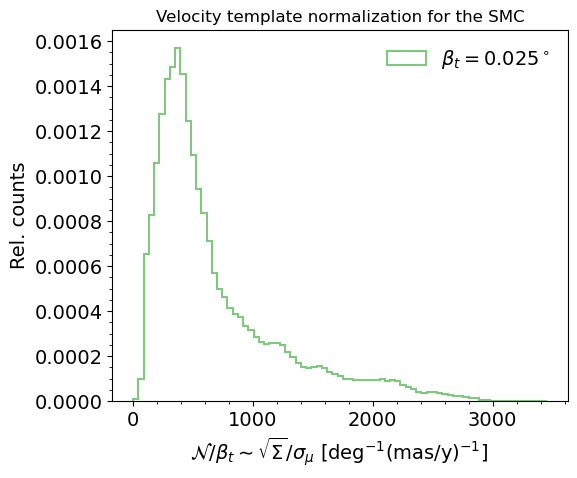

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
cmap = plt.get_cmap('Accent', 10)
xmin, xmax, nbins = 0, 3500, 80
bins_n = np.arange(xmin,xmax, (xmax-xmin)/nbins)

ax.minorticks_on()
ax.hist(template_res[:, ind_n]/(beta_t/degree), bins=bins_n, histtype='step', density=True, linewidth=1.5, color=cmap(0));
ax.legend([r'$\beta_t = $'+str(np.round(beta_t/degree, 5))+'$^\circ$'], loc='upper right', frameon=False, labelspacing=0.2)    
    
ax.set_xlabel(r'$\mathcal{N}/\beta_t \sim \sqrt{\Sigma}/\sigma_\mu\ [\mathrm{deg}^{-1} (\mathrm{mas/y})^{-1}]$ '); ax.set_ylabel(r'Rel. counts'); 
ax.set_title(r'Velocity template normalization for the '+str(sky_p.data_file_name[:3]), fontsize=12);
fig.tight_layout()
#fig.savefig(FigDir+str(sky_p.data_file_name[:3])+'_tau_norm.pdf')

### Tau/N histograms

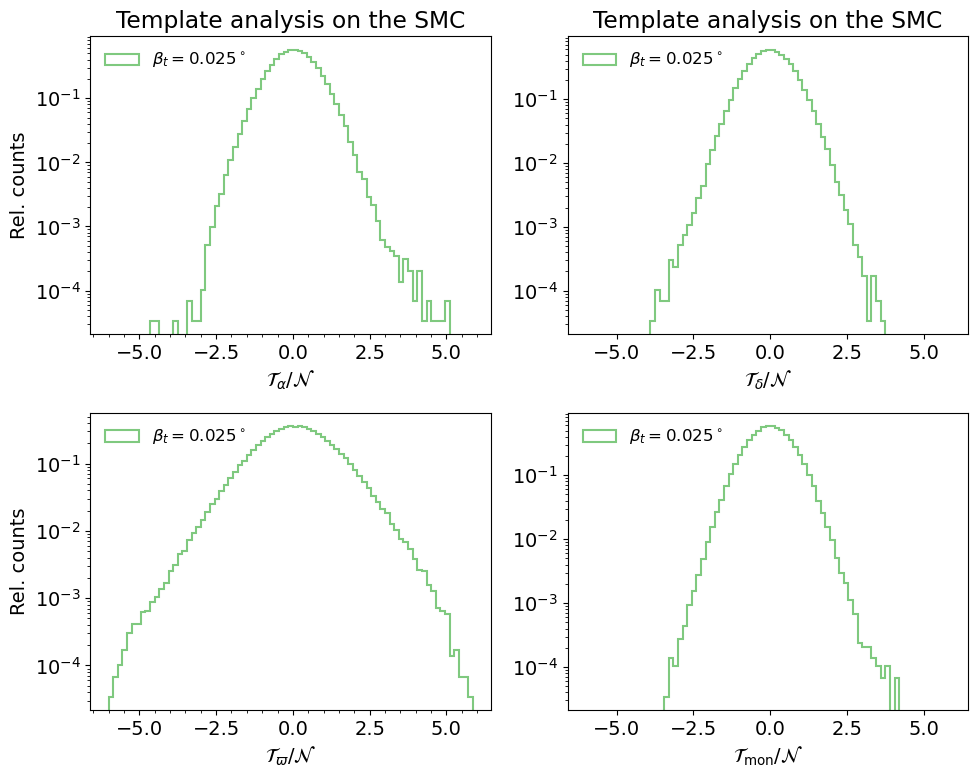

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
cmap = plt.get_cmap('Accent', 10)
xmin, xmax, nbins = -6, 6, 80
bins_t = np.arange(xmin,xmax, (xmax-xmin)/nbins)

ax[0][0].minorticks_on()
ax[1][0].minorticks_on()
ax[0][0].hist(template_res[:, ind_tau_ra]/template_res[:, ind_n], bins=bins_t, histtype='step', log=True, density=True, linewidth=1.5, color=cmap(0));
ax[0][1].hist(template_res[:, ind_tau_dec]/template_res[:, ind_n], bins=bins_t, histtype='step', log=True, density=True, linewidth=1.5, color=cmap(0));
ax[1][0].hist(template_res[:, ind_tau_par]/template_res[:, ind_par_n], bins=bins_t, histtype='step', log=True, density=True, linewidth=1.5, color=cmap(0));
ax[1][1].hist(template_res[:, ind_tau_mon]/template_res[:, ind_tau_mon_n], bins=bins_t, histtype='step', log=True, density=True, linewidth=1.5, color=cmap(0));

ax[0][0].set_xlabel(r'$\mathcal{T}_\alpha/\mathcal{N}$ '); ax[0][0].set_ylabel(r'Rel. counts'); 
ax[0][1].set_xlabel(r'$\mathcal{T}_\delta/\mathcal{N}$ '); 
ax[1][0].set_xlabel(r'$\mathcal{T}_\varpi/\mathcal{N}$ '); ax[1][0].set_ylabel(r'Rel. counts'); 
ax[1][1].set_xlabel(r'$\mathcal{T}_\mathrm{mon}/\mathcal{N}$ '); 
ax[0][0].set_title(r'Template analysis on the '+str(sky_p.data_file_name[:3])); ax[0][1].set_title(r'Template analysis on the '+str(sky_p.data_file_name[:3]));
    
ax[0][0].legend([r'$\beta_t = $'+str(np.round(beta_t/degree, 5))+'$^\circ$'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=12)    
ax[0][1].legend([r'$\beta_t = $'+str(np.round(beta_t/degree, 5))+'$^\circ$'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=12)    
ax[1][0].legend([r'$\beta_t = $'+str(np.round(beta_t/degree, 5))+'$^\circ$'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=12)    
ax[1][1].legend([r'$\beta_t = $'+str(np.round(beta_t/degree, 5))+'$^\circ$'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=12)    
   
fig.tight_layout()
#fig.savefig(FigDir+str(sky_p.data_file_name[:3])+'_tau_hist.pdf')

# Example template scan (on a cluster)

When running on the cluster, one can run the template scanning in parallel.
i.e. divide the n_locations in n_steps (approximately equal to the number of cores available) and
run the template scan at n_locations/n_steps in parallel on each core.

## Preamble

In [27]:
### Read in paramters from the command line.
### Example of how to run the python script with the template scan for beta_t = 0.03 deg, dividing in n_steps and running the 0th step
### python template_scan.py LMC 300 40 0

sky_patch_name = sys.argv[1]  # 'LMC' or 'SMC'
beta_t_deg = sys.argv[2]      # beta_t value to use for the analysis (given in units of degree/10000)
n_steps = int(sys.argv[3])    # i.e. 40 (or equal to the number of cores available)
i_step = int(sys.argv[4])     # from 0 to n_steps-1

In [25]:
### Define sky patch to use in the analysis
if sky_patch_name == 'LMC':    
    sky_p = sky_patch(81.28, -69.78, 5*degree, 50*kpc, 'LMC_disc_5', np.array([1.871, 0.391]), pm_esc=0.2)
    print('********** Template analysis on the LMC for beta_t_deg = **********', beta_t_deg)
elif sky_patch_name == 'SMC':
    sky_p = sky_patch(12.80, -73.15, 4*degree, 60*kpc, 'SMC_disc_4', np.array([0.686, -1.237]), pm_esc=0.2)
    print('********** Template analysis on the SMC for beta_t_deg = **********', beta_t_deg)
else:
    print('ERROR: wrong name provided for the sky patch!')
sys.stdout.flush()

In [51]:
### Parameters for data cleaning
beta_kernel_sub_0 = 0.1*degree; beta_kernel_sub = 0.06*degree;   # gaussian kernels for background subtraction 
n_iter_sub = 3;                                                  # number of iterations for the background subtraction
disc_radius_no_edge = sky_p.disc_radius - beta_kernel_sub_0 - (n_iter_sub+1)*beta_kernel_sub

### Parameters for the template scan
n_betat = 3.5; ### the template is computed for stars within a circle of radius n_betat*beta_t from the template location
beta_t = float(beta_t_deg)/10000*degree

In [4]:
### Import the final data
data = np.load(DataDir+sky_p.data_file_name+'_final.npy') ### Much faster than reading in a csv file

## Execution 

In [ ]:
print('Template scan for beta_t =', np.round(beta_t/degree, 5), 'deg.')
sys.stdout.flush()

### Determine coordinates for the coarse scanning:
### Pixels within a disc of radius disc_radius_no_edge - n_betat_0*beta_t_0 from the stellar target center,
### at an angular scale of approximatly beta_t.
scan_coord = fn_coarse_scan_coord(sky_p.disc_center, disc_radius_no_edge, beta_t, n_betat)
n_locations = len(scan_coord[0])
step = math.ceil(n_locations/n_steps)
max_i_step = math.ceil(n_locations/step)
print('Number of template locations: '+str(n_locations)+'. Dividing in '+str(n_steps)+' steps.')
sys.stdout.flush()

if i_step >= max_i_step:
    print('The step = '+str(i_step)+' is grater than the maximum allowed step = '+str(max_i_step)+'. Not running the template scan.')
    sys.stdout.flush()
else: 
    print('Running step = '+str(i_step)+'.')
    sys.stdout.flush()
    first_loc = step*i_step; last_loc = min(step*(i_step+1), n_locations)
    
    ### Prepare the data for the template scan at beta_t.
    ### Pixelate at angular scale approximatly beta_t/10
    ### Append the stars pixel number as the first column of the array data
    nside, scan_pix, data = fn_prepare_template_scan(data, [scan_coord[0][first_loc:last_loc], scan_coord[1][first_loc:last_loc]], beta_t)

    tic = tictoc()
    ### Compute the templates
    template_res = fn_template_scan(nside, scan_pix, n_betat, beta_t, data)
    ### Save the result of the template scan
    np.save(ListTauDir+sky_p.data_file_name+'_tau_b'+beta_t_deg+'_'+str(i_step), template_res)
    toc = tictoc()    

    print('Template scan completed in', str(toc - tic), 's.')
    sys.stdout.flush()